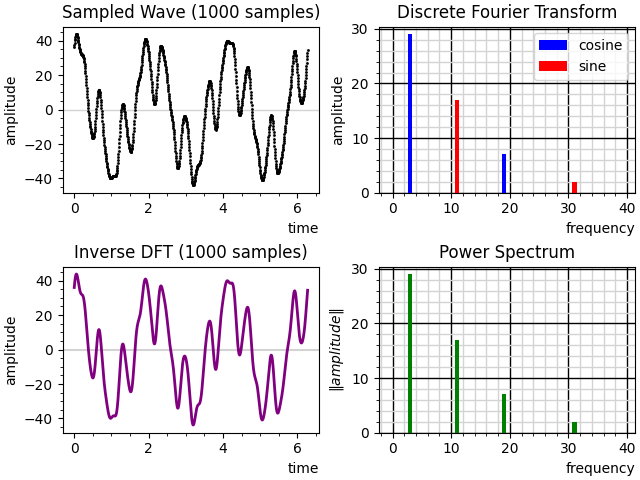

In [4]:
"""fourier_discrete.ipynb"""
# Cell 1

from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget

max_freq: int = 40

# fmt: off

def dft(ts: NDArray[np.float_],
        ys: NDArray[np.float_]
    )-> tuple[NDArray[np.float_], NDArray[np.float_]]:
    num_samples: int = ts.size
    num_terms: int = int(num_samples / 2)  # Nyquist limit

    a_cos: NDArray[np.float_] = np.zeros(num_terms)
    b_sin: NDArray[np.float_] = np.zeros(num_terms)

    for term in range(0, num_terms):
        a: float = 0.0
        b: float = 0.0
        for sample in range(0, num_samples):
            a += 2 * np.cos(term * ts[sample]) * ys[sample]
            b += 2 * np.sin(term * ts[sample]) * ys[sample]
        a_cos[term] = round(a / num_samples, 8) + 0
        b_sin[term] = round(b / num_samples, 8) + 0

    a_cos[0] /= 2
    b_sin[0] /= 2

    return a_cos, b_sin


def idft(a_cos: NDArray[np.float_], b_sin: NDArray[np.float_],
         ts: NDArray[np.float_]) -> NDArray[np.float_]:
    num_terms: int = a_cos.size
    num_points: int = ts.size
    yr: NDArray[np.float_] = np.zeros(num_points)

    for point in range(0, num_points):
        for term in range(0, num_terms):
            yr[point] += a_cos[term] * np.cos(term * ts[point]) + b_sin[term] * np.sin(
                term * ts[point]
            )

    return yr


def power_spec(a_cos: NDArray[np.float_],
               b_sin: NDArray[np.float_]) -> NDArray[np.float_]:
    num_terms: int = a_cos.size
    ps: NDArray[np.float_] = np.zeros(num_terms, dtype=np.float_)
    for term in range(0, num_terms):
        ps[term] = np.sqrt(a_cos[term] ** 2 + b_sin[term] ** 2)
    return ps

# fmt: on


def plot_samples(ts: NDArray[np.float_], ys: NDArray[np.float_], ax: Axes) -> None:
    ax.set_title(f"Sampled Wave ({ts.size} samples)")

    ax.set_xlabel("time", loc="right")
    ax.set_ylabel("amplitude")

    ax.axhline(y=0.0, color="lightgray", linewidth=1)

    # fmt: off
    ax.plot(ts, ys, color="lightgray",
            marker="o", markerfacecolor="none",
            markersize=1, markeredgecolor="black")
    # fmt: on

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_dft(a_cos: NDArray[np.float_], b_sin: NDArray[np.float_], ax: Axes) -> None:
    ax.set_title("Discrete Fourier Transform")

    ax.set_xlabel("frequency", loc="right")
    ax.set_ylabel("amplitude")

    highest_freq: int
    if max_freq:
        highest_freq = max_freq
    else:
        highest_freq = (
            max(int(np.amax(np.nonzero(a_cos))), int(np.amax(np.nonzero(b_sin)))) + 1
        )

    # fmt: off
    
    ax.bar(range(0, highest_freq), a_cos[:highest_freq],
           label="cosine", color="blue", zorder=2)
    
    ax.bar(range(0, highest_freq), b_sin[:highest_freq],
           label="sine", color="red", zorder=2)

    # fmt: on

    ax.legend(loc="best")

    ax.grid(which="major", axis="x", color="black", linewidth=1)
    ax.grid(which="minor", axis="x", color="lightgray", linewidth=1)
    ax.grid(which="major", axis="y", color="black", linewidth=1)
    ax.grid(which="minor", axis="y", color="lightgray", linewidth=1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_idft(ts: NDArray[np.float_], yr: NDArray[np.float_], ax: Axes) -> None:
    ax.set_title(f"Inverse DFT ({ts.size} samples)")

    ax.set_xlabel("time", loc="right")
    ax.set_ylabel("amplitude")

    ax.axhline(y=0.0, color="lightgray")

    ax.plot(ts, yr, color="purple", linewidth=2)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def plot_powerspec(ps: NDArray[np.float_], ax: Axes) -> None:
    ax.set_title("Power Spectrum")

    ax.set_xlabel("frequency", loc="right")
    ax.set_ylabel(r"$\Vert amplitude \Vert$")

    highest_freq: int
    if max_freq:
        highest_freq = max_freq
    else:
        highest_freq = int(np.amax(np.nonzero(ps))) + 1

    ax.bar(range(0, highest_freq), ps[:highest_freq], color="green", zorder=2)

    ax.grid(which="major", axis="x", color="black", linewidth=1)
    ax.grid(which="minor", axis="x", color="lightgray", linewidth=1)
    ax.grid(which="major", axis="y", color="black", linewidth=1)
    ax.grid(which="minor", axis="y", color="lightgray", linewidth=1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


def analyze(file_name: str) -> None:
    samples: NDArray[np.float_] = np.genfromtxt(file_name, delimiter=",")
    ts: NDArray[np.float_] = samples[:, 0]
    ys: NDArray[np.float_] = samples[:, 1]

    a_cos: NDArray[np.float_]
    b_sin: NDArray[np.float_]
    a_cos, b_sin = dft(ts, ys)
    yr: NDArray[np.float_] = idft(a_cos, b_sin, ts)
    ps: NDArray[np.float_] = power_spec(a_cos, b_sin)

    plt.close("all")
    plt.figure(file_name, constrained_layout=True)

    plot_samples(ts, ys, plt.subplot(221))
    plot_dft(a_cos, b_sin, plt.subplot(222))
    plot_idft(ts, yr, plt.subplot(223))
    plot_powerspec(ps, plt.subplot(224))

    plt.show()


analyze("samples.csv")

In [ ]:
# Cell 2

analyze("space_signal1.csv")

In [ ]:
# Cell 3

analyze("space_signal2.csv")

In [ ]:
# Cell 4

analyze("space_signal3.csv")

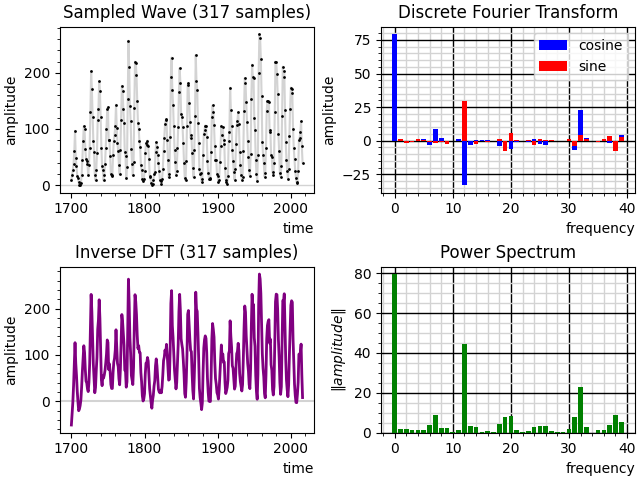

In [5]:
# Cell 5

analyze("sunspots.csv")

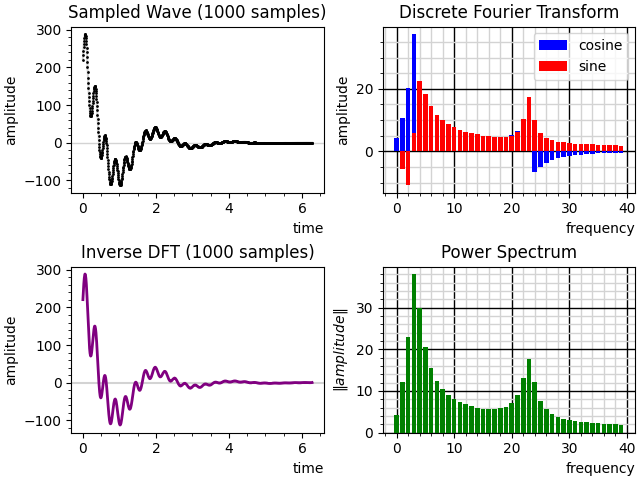

In [7]:
# Cell 6

analyze("samples_decay.csv")

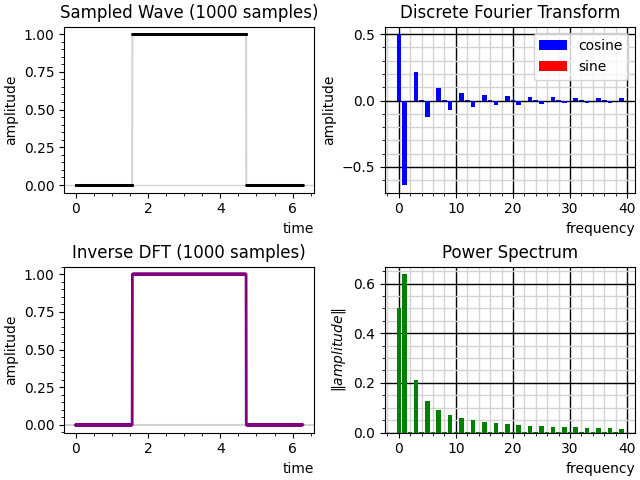

In [6]:
# Cell 7

analyze("samples_square.csv")

In [ ]:
# Cell 8: My answers to Dave's questions
"""
Hi! During this past semester at CMU, I took a whole class on signals which mainly focused on fourier transforms. I know that square waves occur when you overlay a wave and its odd harmonics at multiples of the fundamental freq. Adding these harmonic signals constructively interferes with the base wave in order to make an extremely sharp incline and decline along the edges on the square wave as well as flattening out the 'top' and 'bottom' of the square wave. The more harmonic frequencies you add, the more 'perfect' the wave will be. Freq 0 has an amplitude of 1/2 bc it is the average of the whole wave function. The function spends half the time at 1 at the crest of the wave and half at 0 at the trough; therefore, it makes sense that 1/2 is the average. There is no sign components bc they would destructively interfere with the cos components negating our progress towards making the square wave.
"""